### Lab 3: Expectation Maximization and Variational Autoencoder

### Machine Learning 2 (2018/2019)

* The lab exercises should be made in groups of two or three people.
* The deadline is Friday, 31.05.
* Assignment should be submitted through Canvas! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.
$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### Installing PyTorch

In this lab we will use PyTorch. PyTorch is an open source deep learning framework primarily developed by Facebook's artificial-intelligence research group. In order to install PyTorch in your conda environment go to https://pytorch.org and select your operating system, conda, Python 3.6, no cuda. Copy the text from the "Run this command:" box. Now open a terminal and activate your 'ml2labs' conda environment. Paste the text and run. After the installation is done you should restart Jupyter.

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included. 
Fortunately, PyTorch comes with a MNIST data loader. The first time you run the box below it will download the MNIST data set. That can take a couple of minutes.
The main data types in PyTorch are tensors. For Part 1, we will convert those tensors to numpy arrays. In Part 2, we will use the torch module to directly work with PyTorch tensors.

In [1]:
%pylab inline
import torch
from torchvision import datasets, transforms

train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_labels = train_dataset.train_labels.numpy()
train_data = train_dataset.train_data.numpy()
# For EM we will use flattened data
train_data = train_data.reshape(train_data.shape[0], -1)


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## Part 1: Expectation Maximization
We will use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5 points)
As we like to apply our Bernoulli mixture model, write a function `binarize` to convert the (flattened) MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding at an appropriate level.

In [2]:
def binarize(X, threshold=125):
    return np.array([[float(1) if e > threshold else float(0) for e in d] for d in X])


In [3]:
# Test test test!
bin_train_data = binarize(train_data)
assert bin_train_data.dtype == np.float
assert bin_train_data.shape == train_data.shape


Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

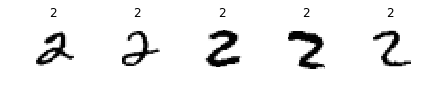

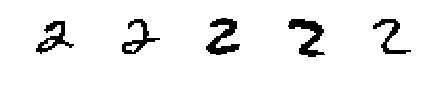

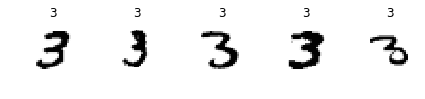

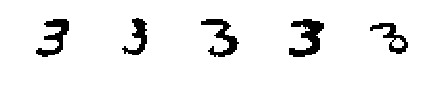

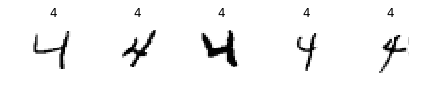

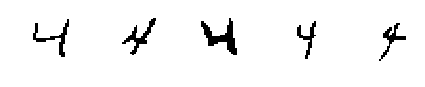

In [4]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

nr = 5

bin_digit_2 = bin_train_data[np.where(train_labels==2)]
bin_digit_3 = bin_train_data[np.where(train_labels==3)]
bin_digit_4 = bin_train_data[np.where(train_labels==4)]

digit_2 = train_data[np.where(train_labels==2)]
digit_3 = train_data[np.where(train_labels==3)]
digit_4 = train_data[np.where(train_labels==4)]

plot_digits(digit_2[0:nr], nr, targets=2*np.ones(nr))
plot_digits(bin_digit_2[0:nr], nr)
plot_digits(digit_3[0:nr], nr, targets=3*np.ones(nr))
plot_digits(bin_digit_3[0:nr], nr)
plot_digits(digit_4[0:nr], nr, targets=4*np.ones(nr))
plot_digits(bin_digit_4[0:nr], nr)


### 1.2 Implementation (40 points)
You are going to write a function ```EM(X, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters the function has are:
* ```X``` :: (NxD) array of input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize computations using ```numpy``` as  much as possible.

You should implement the `E_step(X, mu, pi)` and `M_step(X, gamma)` separately in the functions defined below. These you can then use in your function `EM(X, K, max_iter)`.

In [5]:
def E_step(X, mu, pi):
    
    # calculate values
    gamma = np.array([[pi[k]*np.prod(mu[k,:]**X[n,:]*(1-mu[k,:])**(1-X[n,:])) 
                       for k in range(mu.shape[0])] for n in range(X.shape[0])])
    
    # normalize
    gamma = gamma / np.sum(gamma, axis=1)[:,None]

#     gamma
#     arr[arr > 255] = x
#     # normalize
#     gamma = np.array([gamma[n,:] / sum(gamma[n,:]) if sum(gamma[n,:]) != 0 \
#                       else np.zeros(len(gamma[n,:])) for n in range(gamma.shape[0])])

    return gamma

In [6]:
# Let's test on 5 datapoints
n_test = 5
X_test = bin_train_data[:n_test]
D_test, K_test = X_test.shape[1], 10

np.random.seed(2018)
mu_test = np.random.uniform(low=.25, high=.75, size=(K_test,D_test))
pi_test = np.ones(K_test) / K_test

gamma_test = E_step(X_test, mu_test, pi_test)
assert gamma_test.shape == (n_test, K_test)


In [7]:
def M_step(X, gamma):
    
    nk = np.sum(gamma, axis=0)[:,None]
    
    mu = gamma.T @ X / nk
    pi = (nk / X.shape[0]).reshape(-1)
    
    return mu, pi

In [8]:
# Oh, let's test again
mu_test, pi_test = M_step(X_test, gamma_test)

assert mu_test.shape == (K_test,D_test)
assert pi_test.shape == (K_test, )


In [9]:
def EM(X, K, max_iter, mu=None, pi=None, threshold=0.001):
    
    # initialize if not given
    if mu is None:
        mu = np.random.uniform(low=.25, high=.75, size=(K, X.shape[1]))      
    if pi is None:
        pi = np.ones(K) / K
        
    print('| iteration | convergence mu | convergence pi |')   
    
    i, converged = 0, False
    while i < max_iter and converged == False:
        
        gamma = E_step(X, mu, pi)
        mu_new, pi_new = M_step(X, gamma)
        i += 1
        
        # calculate convergence of mu and pi
        conv_mu = sum(abs(mu_new - mu))
        conv_pi = sum(abs(pi_new - pi))
        print('| %9i | %14f | %14f |' % (i, conv_mu, conv_pi))
        
        if conv_mu < threshold and conv_pi < threshold / 1000:
            converged = True
        else:
            (mu, pi) = (mu_new, pi_new)
        
    return gamma, mu, pi, i

### 1.3 Three digits experiment (10 points)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits.

| iteration | convergence mu | convergence pi |
|         1 |     867.122165 |       0.640499 |
|         2 |      57.916972 |       0.228577 |
|         3 |      34.103832 |       0.136211 |
|         4 |      19.468710 |       0.086018 |
|         5 |      12.481052 |       0.057407 |
|         6 |       9.040945 |       0.033387 |
|         7 |       6.672932 |       0.015862 |
|         8 |       5.129119 |       0.007984 |
|         9 |       4.829328 |       0.002344 |
|        10 |       6.150472 |       0.004523 |
|        11 |       9.413302 |       0.009886 |
|        12 |      15.195789 |       0.019138 |
|        13 |      17.142470 |       0.001329 |
|        14 |      11.582766 |       0.014095 |
|        15 |       6.078327 |       0.009232 |
|        16 |       5.060138 |       0.013487 |
|        17 |       2.633415 |       0.006977 |
|        18 |       2.886490 |       0.010259 |
|        19 |       2.640032 |       0.010515 |
|        20 |       1.896453 |       0.0

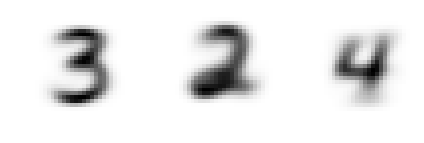

true mixing coefficients: 0.332274 0.341922 0.325804
identified coefficients : 0.307952 0.335510 0.356538


In [10]:
K = 3
max_iter = 100

np.random.seed(2019)
bin_train_data_234 = np.concatenate((bin_digit_2, bin_digit_3, bin_digit_4), axis=0)

gamma_3, mu_3, pi_3, nr_iter_3 = EM(bin_train_data_234, K, max_iter)

plot_digits(mu_3, K)

all_digits = len(bin_train_data_234)
print('true mixing coefficients: %8f %8f %8f' % (len(bin_digit_2)/all_digits,
                                                 len(bin_digit_3)/all_digits,
                                                 len(bin_digit_4)/all_digits))
print('identified coefficients : %8f %8f %8f' % (pi_3[1], pi_3[0], pi_3[2]))  

Can you identify which element in the latent space corresponds to which digit? What are the identified mixing coefficients for digits $2$, $3$ and $4$, and how do these compare to the true ones?

Yes it is clearly visible. The first one corresponds to 3, the second one to 2 and the last one to the digit 4. The identified coefficients are fairly similar to the true mixing coefficients. Interestingly enough, the algorithm overestimates the number of 4's in the dataset, even though one would think these are visually the easiest to distinguish from 2's and 3's.

### 1.4 Experiments (20 points)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation. You may still use your dataset with only digits 2, 3 and 4 as otherwise computations can take very long.

#### 1.4.1 Size of the latent space (5 points)
Run EM with $K$ larger or smaller than the true number of classes. Describe your results.

| iteration | convergence mu | convergence pi |
|         1 |     582.411312 |       0.938907 |
|         2 |      37.557007 |       0.395722 |
|         3 |      23.216287 |       0.300990 |
|         4 |      14.951826 |       0.198368 |
|         5 |      12.970792 |       0.146364 |
|         6 |       6.727180 |       0.073126 |
|         7 |       2.443868 |       0.026471 |
|         8 |       1.163842 |       0.011434 |
|         9 |       0.671185 |       0.006743 |
|        10 |       0.662620 |       0.006118 |
|        11 |       0.847842 |       0.006804 |
|        12 |       0.688252 |       0.005396 |
|        13 |       0.412670 |       0.003388 |
|        14 |       0.706406 |       0.004730 |
|        15 |       0.526656 |       0.003750 |
|        16 |       0.320434 |       0.002227 |
|        17 |       0.175800 |       0.001181 |
|        18 |       0.094072 |       0.000598 |
|        19 |       0.212292 |       0.001045 |
|        20 |       0.292793 |       0.0

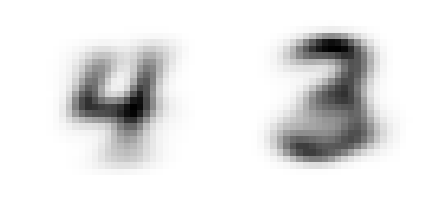

| iteration | convergence mu | convergence pi |
|         1 |    1178.185099 |       0.915862 |
|         2 |     109.103419 |       0.551931 |
|         3 |      47.222683 |       0.140421 |
|         4 |      22.167148 |       0.083550 |
|         5 |      13.969690 |       0.048382 |
|         6 |      10.107211 |       0.030857 |
|         7 |       6.832177 |       0.018283 |
|         8 |       5.359354 |       0.015049 |
|         9 |       3.884743 |       0.009702 |
|        10 |       2.922229 |       0.007326 |
|        11 |       2.668167 |       0.007104 |
|        12 |       1.839673 |       0.003890 |
|        13 |       1.332765 |       0.002148 |
|        14 |       1.232653 |       0.002443 |
|        15 |       1.231542 |       0.003121 |
|        16 |       0.877837 |       0.001726 |
|        17 |       0.726056 |       0.000940 |
|        18 |       0.665384 |       0.000402 |
|        19 |       0.630966 |       0.000344 |
|        20 |       0.602062 |       0.0

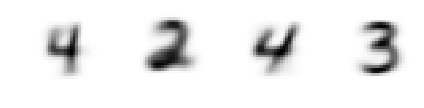

In [11]:
np.random.seed(2019)

K = 2
gamma_2, mu_2, _, _ = EM(bin_train_data_234, K, max_iter)
plot_digits(mu_2, K)

K = 4
gamma_4, mu_4, _, _ = EM(bin_train_data_234, K, max_iter)
plot_digits(mu_4, K)


For K = 2, the convergence is faster (39 iterations compared to 56 for K = 3). The two numbers that are the result of training resemble a 4 and a 3, although the 3 seems a bit warped towards a 2. This makes sense, since the algorithm probably maps 2 and 3 to the same K mean since they look fairly similar.

For K = 4, the convergene is slower (it hits the limit of 100 iterations). This is most likely caused due to the fact that finding more K-means takes more time to converge. The resulting means show that the algorithm has created two means for 4's, one that is a bit italic compared to the other.

#### 1.4.2 Identify misclassifications (10 points)
How can you use the data labels to assign a label to each of the clusters/latent variables? Use this to identify images that are 'misclassified' and try to understand why they are. Report your findings.

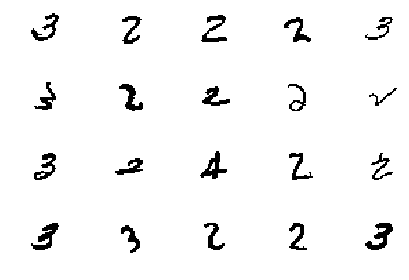

| correctly classified | av std gamma correct | av std gamma incorrect | 
|             0.905136 |             0.470067 |               0.460736 |


In [12]:
lables_234 = np.concatenate((1*np.ones(len(bin_digit_2)), 0*np.ones(len(bin_digit_3)),\
                             2*np.ones(len(bin_digit_4))))
predictions_234 = np.argmax(gamma_3, axis=1) 
correct = (lables_234 == predictions_234)

gamma_corr = [np.std(gamma_3[i]) for i in range(len(correct)) if correct[i] == True]
gamma_incr = [np.std(gamma_3[i]) for i in range(len(correct)) if correct[i] == False]

np.random.seed(2019)
samples_incorrect = []
while len(samples_incorrect) < 20:
    i = int(np.random.uniform(0, len(correct)))
    if correct[i] == False:
        samples_incorrect.append(bin_train_data_234[i])

plot_digits(np.array(samples_incorrect), 5)

print('| correctly classified | av std gamma correct | av std gamma incorrect | \n' +\
      '| %20f | %20f | %22f |' \
      % (sum(correct == True) / len(predictions_234),\
         np.average(gamma_corr), np.average(gamma_incr)))


The above images are sampled from the set of incorrectly classified numbers. Although some of them are easy distinguishable for the human eye, others are written poorly. In general it seems that the algorithm has problems with either very curvy or very straight lines. Also, it seems that the model has more difficulty in classifying the 2's and 3's correctly. This makes sense, since they can look fairly similar.

When checking the average standard deviation of the gamma for the correctly identified images versus the incorrectly identified images, we can see that the latter is a bit lower. This indicates that gamma values for the incorrectly identified images are closer to each other, which can be interpreted to reflect some form of uncertainty by the model.

#### 1.4.3 Initialize with true values (5 points)
Initialize the three classes with the true values of the parameters and see what happens. Report your results.

| iteration | convergence mu | convergence pi |
|         1 |      11.706524 |       0.028250 |
|         2 |       4.202913 |       0.008807 |
|         3 |       2.210389 |       0.002946 |
|         4 |       1.114122 |       0.001566 |
|         5 |       0.587959 |       0.001100 |
|         6 |       0.318268 |       0.000688 |
|         7 |       0.175605 |       0.000428 |
|         8 |       0.095069 |       0.000254 |
|         9 |       0.052947 |       0.000164 |
|        10 |       0.030374 |       0.000109 |
|        11 |       0.017741 |       0.000071 |
|        12 |       0.010524 |       0.000046 |
|        13 |       0.006329 |       0.000030 |
|        14 |       0.003849 |       0.000019 |
|        15 |       0.002364 |       0.000012 |
|        16 |       0.001461 |       0.000008 |
|        17 |       0.000910 |       0.000005 |
|        18 |       0.000570 |       0.000003 |
|        19 |       0.000358 |       0.000002 |
|        20 |       0.000226 |       0.0

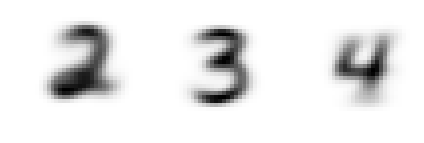

In [13]:
pi_init = np.array([len(bin_digit_2)/len(bin_train_data_234),
                    len(bin_digit_3)/len(bin_train_data_234),
                    len(bin_digit_4)/len(bin_train_data_234)])

mu_init = np.array([np.mean(bin_digit_2, axis=0),
                    np.mean(bin_digit_3, axis=0),
                    np.mean(bin_digit_4, axis=0)])

K = 3
gamma_init, mu_init, _, _ = EM(bin_train_data_234, K, max_iter, mu=mu_init, pi=pi_init)
plot_digits(mu_init, K)

The first thing that can be observed, is the fact that the convergence is much faster in terms of iterations (21 vs 56 for the uninitialized situation). Furthermore, now we can control to which number each mean converges (in this case we used the natural order 2, 3, 4).

## Part 2: Variational Auto-Encoder

A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part $p(\bz | \bx)$ that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

The model was introduced by Diederik Kingma (during his PhD at the UVA) and Max Welling in 2013, https://arxiv.org/abs/1312.6114. 

Since it is such an important model there are plenty of well written tutorials that should help you with the assignment. E.g: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/.

In the following, we will make heavily use of the torch module, https://pytorch.org/docs/stable/index.html. Most of the time replacing `np.` with `torch.` will do the trick, e.g. `np.sum` becomes `torch.sum` and `np.log` becomes `torch.log`. In addition, we will use `torch.FloatTensor()` as an equivalent to `np.array()`. In order to train our VAE efficiently we will make use of batching. The number of data points in a batch will become the first dimension of our data tensor, e.g. A batch of 128 MNIST images has the dimensions [128, 1, 28, 28]. To check check the dimensions of a tensor you can call `.size()`.

### 2.1 Loss function
The objective function (variational lower bound), that we will use to train the VAE, consists of two terms: a log Bernoulli loss (reconstruction loss) and a Kullback–Leibler divergence. We implement the two terms separately and combine them in the end.
As seen in Part 1: Expectation Maximization, we can use a multivariate Bernoulli distribution to model the likelihood $p(\bx | \bz)$ of black and white images. Formally, the variational lower bound is maximized but in PyTorch we are always minimizing therefore we need to calculate the negative log Bernoulli loss and Kullback–Leibler divergence.

### 2.1.1 Negative Log Bernoulli loss (5 points)
The negative log Bernoulli loss is defined as,

\begin{align}
loss = - (\sum_i^D \bx_i \log \hat{\bx_i} + (1 − \bx_i) \log(1 − \hat{\bx_i})).
\end{align}

Write a function `log_bernoulli_loss` that takes a D dimensional vector `x`, its reconstruction `x_hat` and returns the negative log Bernoulli loss. Make sure that your function works for batches of arbitrary size.

In [14]:
def log_bernoulli_loss(x_hat, x):

    loss = torch.zeros(x.size()[1])
    for i in range(x.size()[0]):
        loss -= x[i] * torch.log(x_hat[i]) + (1 - x[i]) * torch.log(1 - x_hat[i])
                    
    return torch.sum(loss)


In [15]:
### Test test test
x_test = torch.FloatTensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.9, 0.9, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33, 0.44], [0.55, 0.66, 0.77, 0.88], [0.99, 0.99, 0.99, 0.99]])

assert log_bernoulli_loss(x_hat_test, x_test) > 0.0
assert log_bernoulli_loss(x_hat_test, x_test) < 10.0


### 2.1.2 Negative Kullback–Leibler divergence (10 Points)
The variational lower bound (the objective to be maximized) contains a KL term $D_{KL}(q(\bz)||p(\bz))$ that can often be calculated analytically. In the VAE we assume $q = N(\bz, \mu, \sigma^2I)$ and $p = N(\bz, 0, I)$. Solve analytically!

\begin{align*}
    q(z) = & N (z, \mu, \sigma^2 I) \\
    p(z) = & N (z, 0, I) \\
    D_{KL}(q(x)||p(z)) = & \int q(z) \log \bigg( \frac{p(z)}{q(z)} \bigg) dz \\
    = & \int q(z) \log \Bigg( \frac{(2 \pi)^{-\frac{k}{2}} \det (I)^{-\frac{1}{2}} \exp \big\{ -\frac{1}{2} z^T I^{-1} z \big\}}{(2 \pi)^{-\frac{k}{2}} \det (\sigma^2 I)^{-\frac{1}{2}} \exp \big\{ -\frac{1}{2} (z - \mu)^T \sigma^2 I^{-1} (z - \mu) \big\}} \Bigg) dz \\
    = & \int q(z) \Bigg( \log \big( \frac{\det (I)^{-\frac{1}{2}}}{\det (\sigma^2 I)^{-\frac{1}{2}}} \big) - \frac{1}{2} z^T I^{-1} z + \frac{1}{2} (z - \mu)^T \sigma^2 I^{-1} (z - \mu) \Bigg) dz \\
    = & -\frac{1}{2} \int q(z) \log \big(\frac{\det (I)}{\det (\sigma^2 I)} \big) dz -\frac{1}{2} \int q(z) z^T I^{-1} z dz + \frac{1}{2} \int q(z) (z - \mu)^T \sigma^2 I^{-1} (z - \mu) dz \\
    = & -\frac{1}{2} \log \big(\frac{\det (I)}{\det (\sigma^2 I)} \big) -\frac{1}{2} \mathbb{E} \lbrack z^T I^{-1} z \rbrack + \frac{1}{2} \mathbb{E} \lbrack (z - \mu)^T \sigma^2 I^{-1} (z - \mu) \rbrack \\
    = & \frac{1}{2} \Bigg( - \log \big(\frac{\det (I)}{\det (\sigma^2 I)} \big) - \mathbb{E} \lbrack z^T I^{-1} z \rbrack + \mathbb{E} \lbrack (z - \mu)^T \sigma^2 I^{-1} (z - \mu) \rbrack \Bigg)\\
    = & \frac{1}{2} \Bigg( - \log \big(\frac{\det (I)}{\det (\sigma^2 I)} \big) - Tr(I) - 0 + Tr(\sigma^2 I) + (\mu - z)^T \sigma^2 I^{-1} (\mu - z) \Bigg)\\
    = & \frac{1}{2}\left( -\log\left(\frac{\det(I)}{\det(diag(\sigma_1^2, ..., \sigma_J^2))}\right) -J + Tr(I^{-1}diag(\sigma_1^2,...,\sigma_J^2)) + (\mu-0)^T \sigma^2 I^{-1}(\mu-0) \right) \\
    = & \frac{1}{2} \left( \mu^T\mu - J - \left(\sum_{i=1}^J \log(\sigma_i^2) \right) \left(\sum_{i=1}^J \sigma_j^2\right) \right)
\end{align*}

Write a function `KL_loss` that takes two J dimensional vectors `mu` and `logvar` and returns the negative Kullback–Leibler divergence. Where `logvar` is $\log(\sigma^2)$. Make sure that your function works for batches of arbitrary size.

In [16]:
def KL_loss(mu, logvar):
    
    loss = np.sum([(1 / 2) * (torch.dot(mu[i],mu[i]) - len(mu[0]) 
                           - torch.sum(logvar[i])
                           + torch.sum(torch.exp(logvar[i])))
                   for i in range(mu.size()[0])])

    return loss

In [17]:
### Test test test
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert KL_loss(mu_test, logvar_test) > 0.0
assert KL_loss(mu_test, logvar_test) < 10.0


### 2.1.3 Putting the losses together (5 points)
Write a function `loss_function` that takes a D dimensional vector `x`, its reconstruction `x_hat`, two J dimensional vectors `mu` and `logvar` and returns the final loss. Make sure that your function works for batches of arbitrary size.

In [18]:
def loss_function(x_hat, x, mu, logvar):
        
    return (log_bernoulli_loss(x_hat,x) + KL_loss(mu, logvar))


In [19]:
x_test = torch.FloatTensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33], [0.44, 0.55, 0.66], [0.77, 0.88, 0.99]])
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert loss_function(x_hat_test, x_test, mu_test, logvar_test) > 0.0
assert loss_function(x_hat_test, x_test, mu_test, logvar_test) < 10.0


### 2.2 The model
Below you see a data structure for the VAE. The modell itself consists of two main parts the encoder (images $\bx$ to latent variables $\bz$) and the decoder (latent variables $\bz$ to images $\bx$). The encoder is using 3 fully-connected layers, whereas the decoder is using fully-connected layers. Right now the data structure is quite empty, step by step will update its functionality. For test purposes we will initialize a VAE for you. After the data structure is completed you will do the hyperparameter search.


In [20]:
from torch import nn
from torch.nn import functional as F 

class VAE(nn.Module):
    def __init__(self, fc1_dims, fc21_dims, fc22_dims, fc3_dims, fc4_dims):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(*fc1_dims)
        self.fc21 = nn.Linear(*fc21_dims)
        self.fc22 = nn.Linear(*fc22_dims)
        self.fc3 = nn.Linear(*fc3_dims)
        self.fc4 = nn.Linear(*fc4_dims)

    def encode(self, x):
        # To be implemented
        raise Exception('Method not implemented')

    def reparameterize(self, mu, logvar):
        # To be implemented
        raise Exception('Method not implemented')

    def decode(self, z):
        # To be implemented
        raise Exception('Method not implemented')

    def forward(self, x):
        # To be implemented
        raise Exception('Method not implemented')

VAE_test = VAE(fc1_dims=(784, 4), fc21_dims=(4, 2), fc22_dims=(4, 2), fc3_dims=(2, 4), fc4_dims=(4, 784))


### 2.3 Encoding (10 points)
Write a function `encode` that gets a vector `x` with 784 elements (flattened MNIST image) and returns `mu` and `logvar`. Your function should use three fully-connected layers (`self.fc1()`, `self.fc21()`, `self.fc22()`). First, you should use `self.fc1()` to embed `x`. Second, you should use `self.fc21()` and `self.fc22()` on the embedding of `x` to compute `mu` and `logvar` respectively. PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.  

In [21]:
def encode(self, x):
    
    out = torch.sigmoid(self.fc1(x))
    
    return self.fc21(out), self.fc22(out)


In [22]:
### Test, test, test
VAE.encode = encode

x_test = torch.ones((5,784))
mu_test, logvar_test = VAE_test.encode(x_test)

assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.4 Reparameterization (10 points)
One of the major question that the VAE is answering, is 'how to take derivatives with respect to the parameters of a stochastic variable?', i.e. if we are given $\bz$ that is drawn from a distribution $q(\bz|\bx)$, and we want to take derivatives. This step is necessary to be able to use gradient-based optimization algorithms like SGD.
For some distributions, it is possible to reparameterize samples in a clever way, such that the stochasticity is independent of the parameters. We want our samples to deterministically depend on the parameters of the distribution. For example, in a normally-distributed variable with mean $\mu$ and standard deviation $\sigma$, we can sample from it like this:

\begin{align}
\bz = \mu + \sigma \odot \epsilon,
\end{align}

where $\odot$ is the element-wise multiplication and $\epsilon$ is sampled from $N(0, I)$.


Write a function `reparameterize` that takes two J dimensional vectors `mu` and `logvar`. It should return $\bz = \mu + \sigma \odot \epsilon$.


In [23]:
def reparameterize(self, mu, logvar):
    
    return mu + logvar * np.random.normal(0, 1)


In [24]:
### Test, test, test
VAE.reparameterize = reparameterize
VAE_test.train()

mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

z_test = VAE_test.reparameterize(mu_test, logvar_test)

assert np.allclose(z_test.size(), [3, 2])
assert z_test[0][0] < 5.0
assert z_test[0][0] > -5.0


### 2.5 Decoding (10 points)
Write a function `decode` that gets a vector `z` with J elements and returns a vector `x_hat` with 784 elements (flattened MNIST image). Your function should use two fully-connected layers (`self.fc3()`, `self.fc4()`). PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.

In [25]:
def decode(self, z):
    
    out = torch.relu(self.fc3(z))
    
    return torch.sigmoid(self.fc4(out))


In [26]:
# test test test
VAE.decode = decode

z_test = torch.ones((5,2))
x_hat_test = VAE_test.decode(z_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert (x_hat_test <= 1).all()
assert (x_hat_test >= 0).all()


### 2.6 Forward pass (10)
To complete the data structure you have to define a forward pass through the VAE. A single forward pass consists of the encoding of an MNIST image $\bx$ into latent space $\bz$, the reparameterization of $\bz$ and the decoding of $\bz$ into an image $\bx$.

Write a function `forward` that gets a a vector `x` with 784 elements (flattened MNIST image) and returns a vector `x_hat` with 784 elements (flattened MNIST image), `mu` and `logvar`.

In [27]:
def forward(self, x):

    mu, logvar = self.encode(x.view(-1, 784))
    x_hat = self.decode(self.reparameterize(mu, logvar))
    
    return x_hat, mu, logvar


In [28]:
# test test test 
VAE.forward = forward

x_test = torch.ones((5,784))
x_hat_test, mu_test, logvar_test = VAE_test.forward(x_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.7 Training (15)
We will now train the VAE using an optimizer called Adam, https://arxiv.org/abs/1412.6980. The code to train a model in PyTorch is given below.

In [29]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


Let's train. You have to choose the hyperparameters. Make sure your loss is going down in a reasonable amount of epochs (around 10).

In [30]:
# Hyperparameters
fc1_dims = (784, 50)
fc21_dims = (50, 2)
fc22_dims = (50, 2)
fc3_dims = (2, 25)
fc4_dims = (25, 784)
lr = 0.002
batch_size = 32
epochs = 10


In [31]:
# This cell contains a hidden test, please don't delete it, thx

Run the box below to train the model using the hyperparameters you entered above.

In [32]:
from torchvision import datasets, transforms
from torch import nn, optim

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/60000 (0%)]	Loss: 546.905396
Train Epoch: 1 [3200/60000 (5%)]	Loss: 207.499268
Train Epoch: 1 [6400/60000 (11%)]	Loss: 211.209732
Train Epoch: 1 [9600/60000 (16%)]	Loss: 208.848434
Train Epoch: 1 [12800/60000 (21%)]	Loss: 200.023743
Train Epoch: 1 [16000/60000 (27%)]	Loss: 194.301483
Train Epoch: 1 [19200/60000 (32%)]	Loss: 183.693069
Train Epoch: 1 [22400/60000 (37%)]	Loss: 182.358780
Train Epoch: 1 [25600/60000 (43%)]	Loss: 171.122391
Train Epoch: 1 [28800/60000 (48%)]	Loss: 184.392838
Train Epoch: 1 [32000/60000 (53%)]	Loss: 155.362061
Train Epoch: 1 [35200/60000 (59%)]	Loss: 174.448288
Train Epoch: 1 [38400/60000 (64%)]	Loss: 175.305359
Train Epoch: 1 [41600/60000 (69%)]	Loss: 152.474335
Train Epoch: 1 [44800/60000 (75%)]	Loss: 175.425583
Train Epoch: 1 [48000/60000 (80%)]	Loss: 167.183578
Train Epoch: 1 [51200/60000 (85%)]	Loss: 178.689850
Train Epoch: 1 [54400/60000 (91%)]	Loss: 167.693649
Train Epoch: 1 [57600/60000 (96%)]	Loss: 172.202759
====> Epoch: 1 Averag

Train Epoch: 9 [6400/60000 (11%)]	Loss: 156.795090
Train Epoch: 9 [9600/60000 (16%)]	Loss: 142.219757
Train Epoch: 9 [12800/60000 (21%)]	Loss: 143.111725
Train Epoch: 9 [16000/60000 (27%)]	Loss: 157.441727
Train Epoch: 9 [19200/60000 (32%)]	Loss: 156.465622
Train Epoch: 9 [22400/60000 (37%)]	Loss: 152.539429
Train Epoch: 9 [25600/60000 (43%)]	Loss: 152.796738
Train Epoch: 9 [28800/60000 (48%)]	Loss: 137.109940
Train Epoch: 9 [32000/60000 (53%)]	Loss: 155.903656
Train Epoch: 9 [35200/60000 (59%)]	Loss: 142.887253
Train Epoch: 9 [38400/60000 (64%)]	Loss: 164.029221
Train Epoch: 9 [41600/60000 (69%)]	Loss: 146.516769
Train Epoch: 9 [44800/60000 (75%)]	Loss: 151.875992
Train Epoch: 9 [48000/60000 (80%)]	Loss: 142.967194
Train Epoch: 9 [51200/60000 (85%)]	Loss: 137.358643
Train Epoch: 9 [54400/60000 (91%)]	Loss: 159.005569
Train Epoch: 9 [57600/60000 (96%)]	Loss: 162.995926
====> Epoch: 9 Average loss: 153.1518
Train Epoch: 10 [0/60000 (0%)]	Loss: 147.065811
Train Epoch: 10 [3200/60000 (5%)

Run the box below to check if the model you trained above is able to correctly reconstruct images.

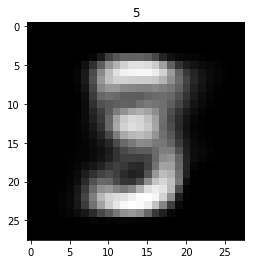

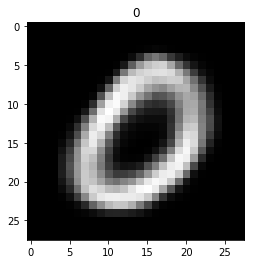

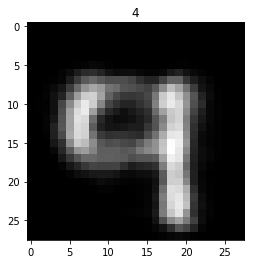

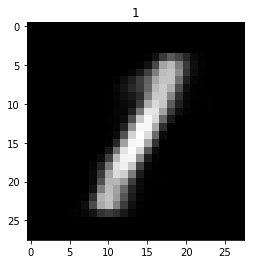

In [33]:
### Let's check if the reconstructions make sense
# Set model to test mode
VAE_MNIST.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu, logvar = VAE_MNIST(data)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 3:
        break


### 2.8 Visualize latent space (20 points)
Now, implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space, as seen in  https://arxiv.org/abs/1312.6114 Figure 4.

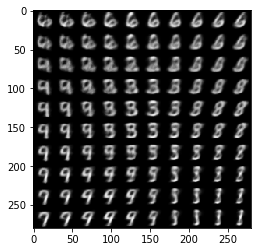

In [34]:
image = np.zeros((280, 280))
for i, x in enumerate(np.linspace(-1, 1, 10)):
    for j, y in enumerate(np.linspace(-1, 1, 10)):
        output = VAE_MNIST.decode(torch.FloatTensor(np.array([[x, y],[x, y]])))\
                          .data.numpy()[0,:]
        image[28*i:28*(i+1), 28*j:28*(j+1)] = output.reshape((28,28))

plt.imshow(image.reshape(280, 280), cmap='gray')
plt.show()

### 2.8 Amortized inference (10 points)
What is amortized inference? Where in the code of Part 2 is it used? What is the benefit of using it?


Instead of learning individual parameters for each observation, parameters of a neural network are optimized. This is done by introducing a parameterized function that maps from observation space to the parameters of the approximate posterior distribution, which is more computationally efficient.

In part 2 this is used where we train the neural network for the encoder.